In [20]:
FOLDER_TEST = "exame-pulmao"
TRAIN_IMG_SRC_FOLDER = "/home/guilherme/Documents/noa/cidia19/data/output-2d/HMV-HCPA/" + FOLDER_TEST
# VALIDATION_IMG_SRC_FOLDER = "/home/guilherme/Documents/noa/cidia19/data/output-2d/HMV-vidro/" + FOLDER_TEST
# VALIDATION_IMG_SRC_FOLDER = "/home/guilherme/Documents/noa/cidia19/data/output-2d/HCPA-vidro/" + FOLDER_TEST
VALIDATION_IMG_SRC_FOLDER = "/home/guilherme/Documents/noa/cidia19/data/output-2d/HMV-HCPA/" + FOLDER_TEST

SUB_FILE = ['axis1', 'axis2']
# SUB_FILE = ['axis2']


EPOCHS = 20
IMG_HEIGHT = 300
IMG_WIDTH = 300 
IMG_CHANNELS = 3
SELECTED_MODEL = ''
NUM_CLASSES = 2
# DATA_FOLDER = '20200827/'
DATA_FOLDER = '20200910/'
LOG_FOLDER = 'logs/' + DATA_FOLDER
TRAINING_FOLDER = 'training/' + DATA_FOLDER
MODEL_FOLDER = 'models/' + DATA_FOLDER
IMAGE_FOLDER = 'images/' + DATA_FOLDER

STRUCTURE_DATASET_FOLDER = "csv/input/"+DATA_FOLDER


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import random

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import glob
import os
from datetime import datetime

import tensorflow as tf

Check if there is available GPU

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
def get_file_path(folder, search_filter=''):
    '''
    Get all files (full path) contained in a PATH folder by specified search filter 
    '''
    paths = []
    for root, dirs, files in os.walk(folder):
        for file in files:
            path = os.path.join(root, file)
            if search_filter in path:
                paths.append(path)
    return paths

def get_data_set(fold_number, cur_subfile, data_train, data_test):
    ''' Creates and returns a dataframe with all the full paths (for slice) for train and test images. 
    Save it as log. 
    '''
    dfs = []
    train_images = {"id": [], "label": []}
    validation_images = {"id": [], "label": []}
    
    
    TRAIN_IMG_FOLDERS_SLICE = {}
    for _, row in data_train.iterrows():
        TRAIN_IMG_FOLDERS_SLICE[row['nome']] = row['covid']

    VALIDATION_IMG_FOLDERS_SLICE = {}
    for _, row in data_test.iterrows():
        VALIDATION_IMG_FOLDERS_SLICE[row['nome']] = row['covid']
    
    df_config = [
        (TRAIN_IMG_SRC_FOLDER, TRAIN_IMG_FOLDERS_SLICE, train_images),
        (VALIDATION_IMG_SRC_FOLDER, VALIDATION_IMG_FOLDERS_SLICE, validation_images)
    ]
    for (base, folder, dic) in df_config:
        for img_folder, img_label in folder.items():
            search_folder = "{}/{}".format(base, img_folder)
            imgs_filename = sorted(get_file_path(search_folder, search_filter = cur_subfile))
            dic["id"].extend(imgs_filename)
            dic["label"].extend([img_label] * len(imgs_filename))

        dfs.append(pd.DataFrame(data=dic))
#     print(dfs)
    train_df, validation_df = dfs[0], dfs[1]


    if not os.path.exists("logs/"): 
        os.mkdir("logs/")
    if not os.path.exists(LOG_FOLDER): 
        os.mkdir(LOG_FOLDER)
        
    train_df.to_csv("{}/train{}.csv".format(LOG_FOLDER, fold_number), index=False)
    validation_df.to_csv("{}/test{}.csv".format(LOG_FOLDER, fold_number), index=False)

    print("Train fold with {} images".format(len(train_df)))
    print(train_df.groupby("label").label.count())
    print()
    print("Validation fold with {} images".format(len(validation_df)))
    print(validation_df.groupby("label").label.count())
    print("-" * 30)
    return (train_df, validation_df)

In [5]:
def get_side(img, side_type, side_size=5):
    height, width, channel=img.shape
    if side_type=="horizontal":
        return np.ones((height,side_size,  channel), dtype=np.float32)*255
        
    return np.ones((side_size, width,  channel), dtype=np.float32)*255

def show_gallery(show="all"):
    n=100
    counter=0
    images=list()
    vertical_images=[]
    rng_state = np.random.get_state()
    np.random.shuffle(train_images["id"])
    np.random.set_state(rng_state)
    np.random.shuffle(train_images["label"])
    for path, target in zip(train_images["id"], train_images["label"]):
        if target!=show and show!="all":
            continue
        counter=counter+1
        if counter%100==0:
            break
        #Image loading from disk as JpegImageFile file format
        img=load_img(path, target_size=(IMG_WIDTH,IMG_HEIGHT))
        #Converting JpegImageFile to numpy array
        img=img_to_array(img)
        
        hside=get_side(img, side_type="horizontal")
        images.append(img)
        images.append(hside)

        if counter%10==0:
            himage=np.hstack((images))
            vside=get_side(himage, side_type="vertical")
            vertical_images.append(himage)
            vertical_images.append(vside)
            
            images=list()

    gallery=np.vstack((vertical_images)) 
    plt.figure(figsize=(12,12))
    plt.xticks([])
    plt.yticks([])
    title = {"all":"All Classifications's",
             "healthy":"Healthy",
             "covid":"Covid-19"}
    plt.title("100 Samples of {} Patients of the training set".format(title[show]))
    plt.imshow(gallery.astype(np.uint8))


In [6]:
#show_gallery("all")

In [7]:
def get_data_generator(dataframe, x_col, y_col, subset=None, shuffle=True, batch_size=32, class_mode="binary"):
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.05,
    horizontal_flip=False,
    width_shift_range=0.1,
    height_shift_range=0.1,
    )
    
    data_generator = datagen.flow_from_dataframe(
        dataframe=dataframe,
        x_col=x_col,
        y_col=y_col,
        subset=subset,
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        class_mode=class_mode,
        # color_mode="rgb",
        batch_size=batch_size,
        shuffle=shuffle
    )
    return data_generator

In [8]:
def get_base_model():
    base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    return base_model

In [9]:
def get_model_vgg16_chico():
    with tf.device('/GPU:0'):
#         conv_base = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
        conv_base = get_base_model()

        conv_base.trainable = True
        set_trainable = False
        for layer in conv_base.layers:
            if layer.name == 'block1_conv1':
                set_trainable = True
            if set_trainable:
                layer.trainable = True
            else:
                layer.trainable = False

        x = conv_base.output
#         model = tf.keras.Sequential()
#         model.add(conv_base)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
#         model.add(tf.keras.layers.GlobalAveragePooling2D())
        preds = tf.keras.layers.Dense(units=NUM_CLASSES, activation = 'softmax')(x)
#         model.add(tf.keras.layers.Dense(units=NUM_CLASSES, activation = 'sigmoid'))

        model = tf.keras.Model(inputs=conv_base.input, outputs=preds)
    
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])
        model.summary()
        return (model, 'vgg16')

In [10]:
def get_model_vgg16():
    with tf.device('/GPU:0'):
        conv_base = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

        conv_base.trainable = True
        set_trainable = False
        for layer in conv_base.layers:
            if layer.name == 'block1_conv1':
                set_trainable = True
            if set_trainable:
                layer.trainable = True
            else:
                layer.trainable = False

        model = tf.keras.Sequential()
        model.add(conv_base)
        model.add(tf.keras.layers.GlobalAveragePooling2D())
        model.add(tf.keras.layers.Dense(units=NUM_CLASSES, activation = 'sigmoid'))

        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])
        model.summary()
        return (model, 'vgg16')

In [11]:
def get_model_resnet50():
    with tf.device('/GPU:0'):
        conv_base = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

        conv_base.trainable = True
#         set_trainable = False
#         for layer in conv_base.layers:
#             if layer.name == 'block1_conv1':
#                 set_trainable = True
#             if set_trainable:
#                 layer.trainable = True
#             else:
#                 layer.trainable = False

        model = tf.keras.Sequential()
        model.add(conv_base)
        model.add(tf.keras.layers.Dense(1024, activation='relu'))
        model.add(tf.keras.layers.Dense(1024, activation='relu'))
        model.add(tf.keras.layers.GlobalAveragePooling2D())
        model.add(tf.keras.layers.Dense(units=NUM_CLASSES, activation = 'sigmoid'))

        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])
        model.summary()
        return (model, 'resnet50')

In [12]:
def train_model(model, train_df, validation_df, epochs, fold, axis):
    batch_size = 16
    train_generator = get_data_generator(train_df, "id", "label", batch_size=batch_size, class_mode="categorical")
    validation_generator = get_data_generator(validation_df, "id", "label", batch_size=batch_size, class_mode="categorical")

    print(train_generator.class_indices)
    print(validation_generator.class_indices)
    
    step_size_train = train_generator.n // train_generator.batch_size
    step_size_validation = validation_generator.n // validation_generator.batch_size

    if step_size_train == 0:
        step_size_train = train_generator.n // 2
        step_size_validation = validation_generator.n // 2
        
        
    # callbacks, save each time
    # training/20200827/vgg16/fold4/axis2
    checkpoint_path = "training/"
    if not os.path.exists("training/"): 
        os.mkdir("training/")
    checkpoint_path = "{}/".format(TRAINING_FOLDER)
    if not os.path.exists(checkpoint_path): 
        os.mkdir(checkpoint_path)
        
    checkpoint_path = "{}/{}/".format(TRAINING_FOLDER, SELECTED_MODEL)
    if not os.path.exists(checkpoint_path): 
        os.mkdir(checkpoint_path)
        
    checkpoint_path = "{}/{}/fold{}/".format(TRAINING_FOLDER, SELECTED_MODEL, fold)
    if not os.path.exists(checkpoint_path): 
        os.mkdir(checkpoint_path)
    
    checkpoint_path = "{}/{}/fold{}/{}/".format(TRAINING_FOLDER, SELECTED_MODEL, fold, axis)
    if not os.path.exists(checkpoint_path): 
        os.mkdir(checkpoint_path)
        
    # Save dict results of history and legend from current model
    # models/20200827/vgg16/fold4/axis2/{history|legend}
    if not os.path.exists("models/"): 
        os.mkdir("models/")
    
    model_dir = "{}/".format(MODEL_FOLDER)
    if not os.path.exists(model_dir): 
        os.mkdir(model_dir)
        
    model_dir = "{}/{}".format(MODEL_FOLDER, SELECTED_MODEL)
    if not os.path.exists(model_dir): 
        os.mkdir(model_dir)
        
    model_dir = "{}/{}/fold{}/".format(MODEL_FOLDER, SELECTED_MODEL, fold)
    if not os.path.exists(model_dir): 
        os.mkdir(model_dir)
    
    model_dir = "{}/{}/fold{}/{}/".format(MODEL_FOLDER, SELECTED_MODEL, fold, axis)
    if not os.path.exists(model_dir): 
        os.mkdir(model_dir)
    
    checkpoint_path = checkpoint_path + "/cp-{epoch:04d}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create a callback that saves the model's weights every 25 epochs
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path, 
        verbose=1, 
        save_weights_only=True,
        period=25)
        
    history = model.fit(train_generator, # X_Train
        steps_per_epoch=step_size_train,
        epochs=epochs, 
        validation_data=validation_generator,
        validation_steps=step_size_validation,
        callbacks=cp_callback
                       )
    
    # Save last values
    model.save_weights(checkpoint_dir+"/my_checkpoint")
#     model.save(checkpoint_dir+"/my_checkpoint")
    
    # Save history
    hist_df = pd.DataFrame(history.history) 
    hist_csv_file = model_dir + 'history.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
    
    # Save classes
    print(train_generator.class_indices)
    np.save(model_dir + 'legend', train_generator.class_indices)
    return history.history

In [13]:

def plot_results(history, sub_folder, fold, sel_model):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']

    
    image_dir = "images/"
    if not os.path.exists(image_dir): 
        os.mkdir(image_dir)
    
    image_dir = "{}/".format(IMAGE_FOLDER)
    if not os.path.exists(image_dir): 
        os.mkdir(image_dir)
    
    image_dir = "{}/{}/".format(IMAGE_FOLDER, SELECTED_MODEL)
    if not os.path.exists(image_dir): 
        os.mkdir(image_dir)
    
    image_dir = "{}/{}/fold{}/".format(IMAGE_FOLDER, SELECTED_MODEL, fold)
    if not os.path.exists(image_dir): 
        os.mkdir(image_dir)
    
    image_dir = "{}/{}/fold{}/{}/".format(IMAGE_FOLDER, SELECTED_MODEL, fold, axis)
    if not os.path.exists(image_dir): 
        os.mkdir(image_dir)
    
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and Validation accuracy')
    plt.legend()
    plt.savefig(image_dir + 'accuracy', pad_inches=0.1)
    
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()
    
    plt.savefig(image_dir + 'loss', orientation='portrait', pad_inches=0.1)

    plt.show()

Function to evaluate model for data folders (patients).

In [14]:
def predictions_by_patient(model, patients, legend_file, axis):
    results = []
    for p in patients:
        # for axis in SUB_FILE:
        curr_dir = "{}/{}/{}".format(VALIDATION_IMG_SRC_FOLDER, p, axis)
        # print(curr_dir)
        imgs_filename = sorted(os.listdir(curr_dir))
        test_filenames = imgs_filename[:]
        test_df = pd.DataFrame({
                'filename': test_filenames
            })
        nb_samples = test_df.shape[0]

        test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
        test_generator = test_gen.flow_from_dataframe(
                test_df, 
                curr_dir, 
                x_col='filename',
                y_col=None,
                class_mode=None,
                target_size=(IMG_WIDTH, IMG_HEIGHT),
                batch_size=16,
                shuffle=False
        )

        predict = model.predict(test_generator, steps=np.ceil(nb_samples/16))
#         print(predict)
#         test_df['category'] = [int(round(p[1])) for p in predict]
        test_df['category'] = [np.where(pr == np.max(pr))[0][0] for pr in predict]
        test_df['patient'] = p
        test_df['axis'] = axis
        results.append(test_df)

    print('Axis: ', test_df['axis'][0])
    df_result = pd.DataFrame(columns=['category', 'patient','count'])
    for i,test_df in enumerate(results):
        cur_patient = test_df['patient'][0]
        if os.path.isfile(legend_file+'.npy'):
            class_indices = np.load(legend_file+'.npy', allow_pickle=True).item()
            class_indices = dict((v,k) for k,v in class_indices.items())
#             print(class_indices)
            test_df['category'] = test_df['category'].replace(class_indices)
        test_df['count'] = 1
        test_df = test_df.groupby('category', as_index = False)['count'].count()
        test_df['patient'] = cur_patient
        df_result = df_result.append(test_df)
#     print(df_result)
    return df_result
        
    

Call the model for 'axis1...n' and folds [ 1...N ]




Fold 5
Train fold with 9348 images
label
NEGATIVE    2706
POSITIVE    6642
Name: label, dtype: int64

Validation fold with 2870 images
label
NEGATIVE     902
POSITIVE    1968
Name: label, dtype: int64
------------------------------

axis2
=====
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 10, 10, 2048)      23587712  
_________________________________________________________________
dense_15 (Dense)             (None, 10, 10, 1024)      2098176   
_________________________________________________________________
dense_16 (Dense)             (None, 10, 10, 1024)      1049600   
_________________________________________________________________
global_average_pooling2d_15  (None, 1024)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 2050      
Tot

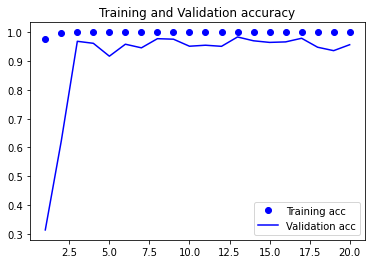

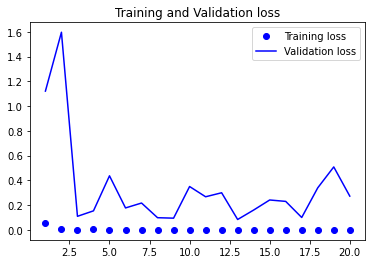

Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 164 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image fi

In [19]:
for axis in SUB_FILE:
    for n_fold in [1, 2, 3, 4, 5]:
        print("\n\n\nFold", str(n_fold))
        
        data_train = pd.read_csv("{}/train/train{}.csv".format(STRUCTURE_DATASET_FOLDER, n_fold))
        data_validation = pd.read_csv("{}/test/test{}.csv".format(STRUCTURE_DATASET_FOLDER, n_fold))
        train_df, validation_df = get_data_set(n_fold, axis, data_train, data_validation)
        
        print('\n'+axis+'\n=====')
#         model, SELECTED_MODEL = get_model_vgg16()
        model, SELECTED_MODEL = get_model_resnet50()
        history = train_model(model, train_df, validation_df, EPOCHS, n_fold, axis)
        
        #Plot Results
        plot_results(history, axis, n_fold, SELECTED_MODEL)
        
        # Test with other patients
        legend_path = "{}/{}/fold{}/{}/legend".format(MODEL_FOLDER, SELECTED_MODEL, n_fold, axis)
        df = predictions_by_patient(model, data_validation['nome'].to_list(), legend_path, axis)

## Check models!
Load saved model

In [ ]:
# model, SELECTED_MODEL = get_model_resnet50()
model, SELECTED_MODEL = get_model_vgg16()

# model.load_weights('training/resnet50/5fold/axis1/my_checkpoint')
fold = 1
axis = 'axis1'
legend_path = "{}/{}/fold{}/{}/legend".format(MODEL_FOLDER, SELECTED_MODEL, fold, axis)
model.load_weights("{}/{}/fold{}/{}/my_checkpoint".format(TRAINING_FOLDER, SELECTED_MODEL, fold, axis))

# data_test =  ['C77', 'C117', 'C136', 'C80', 'C91', 'C104', 'C62', 'C147', 'C106', 'C68', 'C123', 'C99', 'C129']
# HCPA
# data_test = ['NEG-001', 'NEG-002', 'NEG-003', 'NEG-004', 'NEG-005', 'NEG-006', 'NEG-007', 'NEG-008', 'NEG-009', 
#              'NEG-010', 'NEG-011', 'NEG-012', 'NEG-013', 'NEG-014', 'NEG-015', 'TYP-002', 'TYP-003', 'TYP-004', 
#              'TYP-005', 'TYP-006', 'TYP-007', 'TYP-008', 'TYP-009', 'TYP-010', 'TYP-011', 'TYP-012', 'TYP-013', 
#              'TYP-014', 'TYP-015', 'TYP-016', 'TYP-017', 'TYP-018', 'TYP-019', 'TYP-020', 'TYP-021', 'TYP-022', 
#              'TYP-023', 'TYP-024', 'TYP-025', 'TYP-026', 'TYP-027', 'TYP-028', 'TYP-029', 'TYP-030', 'TYP-031']

# HMV - CT Indeterminados - PCR Negativo
# data_test = ['C8', 'C28', 'C30', 'C31', 'C34', 'C37', 'C38', 'C45', 'C47', 'C54', 'C68', 'C72', 'C84', 'C98', 
#              'C99', 'C109', 'C119', 'C123', 'C129', 'C139', 'C140', 'C148', 'C156']

# HMV - CT Indeterminados - PCR Positivo
# data_test = ['C40', 'C48', 'C57', 'C65', 'C97', 'C107', 'C128']

# HMV - Atípicos
# data_test = ['C9', 'C43', 'C55', 'C56', 'C58', 'C59', 'C64', 'C67', 'C70', 'C73', 'C81', 'C118', 'C122', 'C127', 
#              'C134', 'C141', 'C164']

# HMV - CT Típico - PCR negativo
# data_test = ['C71', 'C101', 'C143', 'C162'] 

# HMV - CT Negativo - PCR positivo
data_test = ['C76', 'C105']

# VALIDATION_IMG_SRC_FOLDER = "/home/guilherme/Documents/noa/cidia19/data/output-2d/HCPA/exame-pulmao"
VALIDATION_IMG_SRC_FOLDER = "/home/guilherme/Documents/noa/cidia19/data/output-2d/HMV/exame-pulmao"

df = predictions_by_patient(model, data_test, legend_path, axis)

In [ ]:
df.tail(50)

In [21]:
'''
HMV
'''
for axis in SUB_FILE:
    print('\n'+axis+'\n=====')
    for n_fold in [1, 2, 3, 4, 5]:
        print("\n\n\nFold", str(n_fold))
        
        data_validation = pd.read_csv("{}/test/test{}.csv".format(STRUCTURE_DATASET_FOLDER, n_fold))
        
        model, SELECTED_MODEL = get_model_resnet50()
#         model, SELECTED_MODEL = get_model_vgg16()
        legend_path = "{}/{}/fold{}/{}/legend".format(MODEL_FOLDER, SELECTED_MODEL, n_fold, axis)
        model.load_weights("{}/{}/fold{}/{}/my_checkpoint".format(TRAINING_FOLDER, SELECTED_MODEL, n_fold, axis))
        
        # Test with other patients
        df = predictions_by_patient(model, data_validation['nome'].to_list(), legend_path, axis)
        idx = df.groupby(['patient'])['count'].transform(max) == df['count']
        print(df[idx][['category', 'patient', 'count']].to_string(index=False))


axis1
=====



Fold 1
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 10, 10, 2048)      23587712  
_________________________________________________________________
dense_18 (Dense)             (None, 10, 10, 1024)      2098176   
_________________________________________________________________
dense_19 (Dense)             (None, 10, 10, 1024)      1049600   
_________________________________________________________________
global_average_pooling2d_16  (None, 1024)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 2050      
Total params: 26,737,538
Trainable params: 26,684,418
Non-trainable params: 53,120
_________________________________________________________________
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 8

Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Axis:  axis1
 category  patient count
 NEGATIVE     C102    82
 NEGATIVE     C159    82
 NEGATIVE      C29    82
 NEGATIVE      C46    82
 POSITIVE      C50    43
 POSITIVE     C103    82
 POSITIVE     C112    82
 NEGATIVE     C114    67
 POSITIVE      C12    82
 POSITIVE     C158    82
 POSITIVE      C18    82
 POSITIVE      C20    82
 POSITIVE      C35    82
 POSITIVE      C41    82
 POSITIVE      C44    71
 NEGATIVE      C82    82
 POSITIVE      C83    82
 POSITIVE      C88    82
 POSITIVE      C90    82
 NEGATIVE  NEG-010    79
 NEGATIVE  NEG-014    82
 POSITIVE  TYP-010    78
 POSITIVE  TYP-016    82
 POSITIVE  TYP-017    82
 POSITIVE  TYP-019    82
 POSITIVE  TYP-023    82



Fold 4
Model: "sequen

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 10, 10, 2048)      23587712  
_________________________________________________________________
dense_33 (Dense)             (None, 10, 10, 1024)      2098176   
_________________________________________________________________
dense_34 (Dense)             (None, 10, 10, 1024)      1049600   
_________________________________________________________________
global_average_pooling2d_21  (None, 1024)              0         
_________________________________________________________________
dense_35 (Dense)             (None, 2)                 2050      
Total params: 26,737,538
Trainable params: 26,684,418
Non-trainable params: 53,120
_________________________________________________________________
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filen

Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Axis:  axis2
 category  patient count
 NEGATIVE     C102    82
 NEGATIVE     C159    82
 NEGATIVE      C29    82
 NEGATIVE      C46    82
 NEGATIVE      C50    64
 POSITIVE     C103    82
 POSITIVE     C112    71
 NEGATIVE     C114    82
 POSIT

Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Axis:  axis2
 category  patient count
 NEGATIVE       C5    82
 NEGATIVE     C126    82
 NEGATIVE     C137    82
 NEGATIVE      C22    81
 NEGATIVE      C42    64
 NEGATIVE      C63    82
 POSITIVE      C66    54
 NEGATIVE      C78    82
 POSIT

In [ ]:
'''
HCPA
'''
data_test = ['NEG-001', 'NEG-002', 'NEG-003', 'NEG-004', 'NEG-005', 'NEG-006', 'NEG-007', 'NEG-008', 'NEG-009', 
             'NEG-010', 'NEG-011', 'NEG-012', 'NEG-013', 'NEG-014', 'NEG-015', 'TYP-002', 'TYP-003', 'TYP-004', 
             'TYP-005', 'TYP-006', 'TYP-007', 'TYP-008', 'TYP-009', 'TYP-010', 'TYP-011', 'TYP-012', 'TYP-013', 
             'TYP-014', 'TYP-015', 'TYP-016', 'TYP-017', 'TYP-018', 'TYP-019', 'TYP-020', 'TYP-021', 'TYP-022', 
             'TYP-023', 'TYP-024', 'TYP-025', 'TYP-026', 'TYP-027', 'TYP-028', 'TYP-029', 'TYP-030', 'TYP-031']

for axis in SUB_FILE:
    print('\n'+axis+'\n=====')
    for n_fold in [1, 2, 3, 4, 5]:
        print("\n\n\nFold", str(n_fold))        
#         model, SELECTED_MODEL = get_model_resnet50()
        model, SELECTED_MODEL = get_model_vgg16()
        legend_path = "{}/{}/fold{}/{}/legend".format(MODEL_FOLDER, SELECTED_MODEL, n_fold, axis)
        model.load_weights("{}/{}/fold{}/{}/my_checkpoint".format(TRAINING_FOLDER, SELECTED_MODEL, n_fold, axis))
        
        # Test with other patients
        df = predictions_by_patient(model, data_test, legend_path, axis)
        idx = df.groupby(['patient'])['count'].transform(max) == df['count']
        print(df[idx][['category', 'patient', 'count']].to_string(index=False))

In [ ]:
for axis in SUB_FILE:
    print('\n'+axis+'\n=====')
    for n_fold in [1, 2, 3, 4, 5]:
        print("\n\n\nFold", str(n_fold))        
#         model, SELECTED_MODEL = get_model_resnet50()
        df = pd.read_csv("{}/{}/fold{}/{}/history.csv".format(MODEL_FOLDER, SELECTED_MODEL, n_fold, axis))
        print(max(df['val_accuracy']))
